In this project we'll create a model to predict whether a burrito is `'Great'` and determine what features are most important in determining so.

The dataset comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

---

In [ ]:
#Importing data
%%capture
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
filepath = DATA_PATH + 'burritos/burritos.csv'
!pip install category_encoders==2.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 3.7 MB/s 


# I. Wrangle Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date').sort_index()
                     
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])
    
    #isolating binary columns to replace x's and NaN's to 0's & 1's
    binary_cols=['Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
       'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini', 'Queso']

    #Replacing with 0's and 1's
    df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if type(x) == str else 0)
    
    #Narrowing down burrito types to 4 kinds and then one-hot-encoding the long way
    burrito_type = ['california', 'asada', 'surf', 'carnitas']
    for b in burrito_type:
      df[b] = df['Burrito'].str.lower().str.contains(b).astype(int)

    #No longer need burrito column so drop it
    df = df.drop(columns=['Burrito'])


    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

# Exploratory Data Analysis

In [ ]:
df = wrangle(filepath)
df.head()

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,...,Bacon,Sushi,Avocado,Corn,Zucchini,Great,california,asada,surf,carnitas
Date,,,,,,,,,,,,,,,,,,,,,
2011-05-16,NaN,NaN,0,8.00,4.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2015-04-20,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2016-01-18,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2016-01-24,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2016-01-24,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#df['Beef'].value_counts()

Changing columns so they are properly encoded as `0` and `1`s.

In [ ]:
#df.info()

In [ ]:
# df['Queso'].value_counts()
# df['Queso'].nunique()
# df['Queso'].head()

In [ ]:
#All ingredients besides Queso fall under objects so we will narrow down to 
#object columns only
#df.select_dtypes('object').info()

#object_cols = df.select_dtypes('object')
#object_cols.columns

In [ ]:
#checking the non-ingredients for binary-ness
# df['Reviewer'].value_counts() #go
# df['Burrito'].value_counts() #go
# df['NonSD'].value_counts() #stay
# df['Unreliable'].value_counts() #stay

In [ ]:
#Since it's not safe to assume the nonbinary columns NaN values are 0, we'll separate them
#Deleting nonbinary columns and keeping ingredients only
#Don't forget we have to add Queso back in
#binary_cols=['Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico',
#       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
#       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
#       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
#       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
#       'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini', 'Queso']

In [ ]:
#Now we are going to fill in the NaNs in these specific columns with 0's

#this method doesn't work:
#df[binary_cols]=df[binary_cols].fillna(0)
#Now we are going to fill in all non-zero values with 1's
#doesn't work:
#df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x != 0)

#from solution video:
#df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if type(x) == str else 0)
#df.head()

In [ ]:
#type(df['Unreliable'][0])

# Feature engineering
Replacing `Burrito` column with four most common entries being `california`, `asada`, `surf`, and `carnitas` as their own columns since the `Burrito` column is high cardinality and has a lot of variations of the same kind of buttito just under different names.

In [ ]:
#burrito_type = ['california', 'asada', 'surf', 'carnitas']

#for b in burrito_type:
#  df[b] = df['Burrito'].str.lower().str.contains(b).astype(int)
#df.head()


In [ ]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

# Split Data

We want to predict `'Great'`.

In [ ]:
# Note: to explore the Datetime column of my datframe, have to leave 
# Date as a regular column so it can be manipulated, otherwise as an index, 
# makes it harder

In [ ]:
#df.index.max(), df.index.min()

In [ ]:
# df['year']= df['Date'].dt.year
# df.head()

In [ ]:
#type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
#df['Date'].hist(bins=50)

In [ ]:
#df['year'].value_counts()
#df = df.drop('year')

In [ ]:
target = 'Great'
X = df.drop(columns=target)
y = df[target]

Splitting `X` and `y` into a training set and a test set.

In [ ]:
#df.head()
#type(X.index)

In [ ]:
cutoff = '2018-01-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [ ]:
print(df.shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(421, 62)
(383, 61)
(383,)
(38, 61)
(38,)


# Establish Baseline

Since this is a **classification** problem, we establish a baseline accuracy score based on the majority class in `y_train` and the percentage training observations it represents. 

In [ ]:
y_train.value_counts() #majority belongs to "Not Great"

0    223
1    160
Name: Great, dtype: int64

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5822454308093995


# Build Model

In [ ]:
df.select_dtypes('object')

,Reviewer
Date,
2011-05-16,Albert N
2015-04-20,Erica
2016-01-18,Scott
2016-01-24,Ricardo
2016-01-24,Emily
...,...
2019-08-27,Derek
2019-08-27,Claire
2019-08-27,Max


In [ ]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder #for the reviewers
from sklearn.impute import SimpleImputer #fill in the rest of my nonbinary numerical columns with the mean
from sklearn.preprocessing import StandardScaler #Standard practice, (takes away bias of the different units)
from sklearn.linear_model import LogisticRegression #since my target is binary/categorical

model_logr = make_pipeline(OneHotEncoder(use_cat_names=True),
                           SimpleImputer(),
                           StandardScaler(),
                           LogisticRegression())
model_logr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Reviewer'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

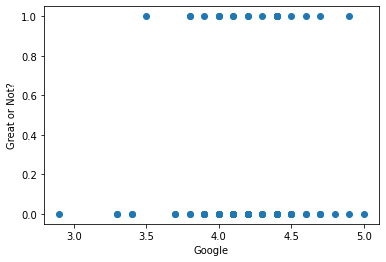

In [ ]:
plt.scatter(X_train['Google'], y_train)
plt.xlabel('Google')
plt.ylabel('Great or Not?')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
#Number of predictions that our model got right
#InOtherWords: number of correct predictions / total number of predictions
training_acc = accuracy_score(y_train, model_logr.predict(X_train))
test_acc = accuracy_score(y_test, model_logr.predict(X_test))

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.9738903394255874
Test MAE: 0.7894736842105263


# Communicate Results

Horizontal barchart plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

Text(0.5, 0, 'Feature Importance')

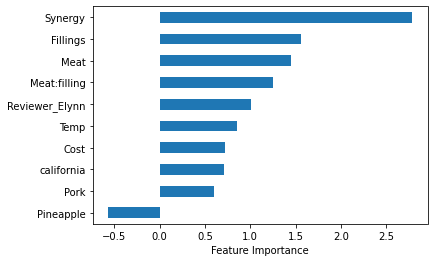

In [ ]:
coefficients = model_logr.named_steps['logisticregression'].coef_[0]
features = model_logr.named_steps['onehotencoder'].get_feature_names()
feat_importance = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_importance.tail(10).plot(kind='barh');
plt.xlabel('Feature Importance')
#This bar chart shows the feature importance relative to each other given we used StandardScaler

It appears that the overall synergy is the most influential factor in determining whether a burrito is great or not. Looking at solely ingredients though, we see that a burrito containing meat or not is what makes it great.

In [ ]:
#print(coefficients.shape)
type(features)
type(coefficients)

numpy.ndarray

# Generating Predictions

In [ ]:
X_test.shape

(38, 61)

In [ ]:
# Exploring the differences between `predict` and `predict_proba`.
print(model_logr.predict(X_test))
print(model_logr.predict(X_test).shape)
print(model_logr.predict_proba(X_test).shape)
np.round(model_logr.predict_proba(X_test),3)

[1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1
 1]
(38,)
(38, 2)


array([[0.001, 0.999],
       [0.95 , 0.05 ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.972, 0.028],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.015, 0.985],
       [0.17 , 0.83 ],
       [0.768, 0.232],
       [0.972, 0.028],
       [0.365, 0.635],
       [0.341, 0.659],
       [0.018, 0.982],
       [0.027, 0.973],
       [0.023, 0.977],
       [0.997, 0.003],
       [0.999, 0.001],
       [1.   , 0.   ],
       [0.998, 0.002],
       [0.005, 0.995],
       [0.958, 0.042],
       [0.042, 0.958],
       [0.402, 0.598],
       [0.934, 0.066],
       [0.997, 0.003],
       [0.   , 1.   ],
       [0.053, 0.947],
       [0.365, 0.635],
       [0.227, 0.773],
       [0.998, 0.002],
       [0.003, 0.997],
       [0.   , 1.   ],
       [0.985, 0.015],
       [0.002, 0.998],
       [0.168, 0.832],
       [0.01 , 0.99 ],
       [0.   , 1.   ]])

In [ ]:
type(model_logr.predict(X_test))

numpy.ndarray

In [ ]:
type(model_logr.predict_proba(X_test))

numpy.ndarray


Both methods are numpy arrays. 
The shape of predict is (38,) and the shape of predict_proba is (38,2). Predict_proba has two columns because it is giving the degree of certainty that a certain prediction about whether a burrito is great or not is true. So basically 'predict' is taking into account both this probability and the cutoff threshold to output a 0 or a 1, 0 being a not great burrito and 1 being a great burrito.